---
title: Analysing reddit data - part 4: data analysis  
date: 2015-12-09  
comments: false  
tags: Python, Programming tips, pandas, scipy, matplotlib, hypothesis testing  
keywords: python, programming, reproducible research, pandas, scipy, hypothesis testing, non-parametric tests, matplotlib  

---

This week ends a 4-part series on extracting and analysing JSON-encoded data from reddit, using the subreddit [/r/relationships](https://www.reddit.com/r/relationships#hme) as an example. In the first two entries I [set up the environment]({filename}2015-11-18-reddit-api-part-1.md) and [collected the data]({filename}2015-11-25-reddit-api-part-2.md). [Last week]({filename}2015-12-02-reddit-api-part-3.md), I finished by cleaning the data and doing some basic analyses. This week we'll finish with some fairly simple bivariate analyses. We'll answer some questions about both posters to the subreddit and how the readers react to these posts, and play around with visualisation in `matplotlib`. In the interest of brevity (i.e., not having to check parametric assumptions), I'll be using non-parametric tests, but if you were doing this properly (not being lazy!) you would need to complete all of these checks and consider the use of parametric tests.

(**Note**: If you have been following this tutorial from the beginning, I have made a correction to Part 1. When I initially created my virtualenv, I forgot to install the `scipy` package. If you do not have `scipy` installed, please go back and install that before starting.)

So let's see what relationships problems the good people of reddit write in about!

<img src="/figure/Lichtenstein_picture.jpg" title="Lichtenstein picture" alt="Copy of Lichtenstein print" style="display: block; margin: auto;" />

## Questions about posters to the subreddit

Let's start by testing some hypotheses about the posters to the site. As we have the sex of the posters, the questions that immediately jump out at me are whether sex has a relationship with a) age and b) the type of posts (flairs) on the subreddit.

### Does the age distribution vary by sex?

The first question I will explore is whether the age distribution of the posters differs between sexes. To start, I'll compute the median age of both men and women.

In [92]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd

rel_df['PosterAge'].groupby([rel_df['PosterSex']]).median()

PosterSex
F    26
M    27
Name: PosterAge, dtype: float64

Hmmm, it looks like there might be a difference, with male posters being older on average than female posters. To test this, I constructed a hypothesis that men are significantly older than women (at the 0.05 level). I can assess this using a [Wilcoxon rank-sum test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test), which is given by the `ranksums` [function](http://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.ranksums.html) in the `scipy` package. As I'm predicting that one group is larger than another I should use a one-sided test, so I divide the returned p-value by 2.

In [3]:
from scipy import stats  

d = {}
for key, value in rel_df.groupby('PosterSex'):
        d['%s' % key] = value['PosterAge']

u_stat, p_val = stats.ranksums(d['M'], d['F'])
print "The test statistic is %1.3f, and the significance level is %1.3f." % (u_stat, p_val / 2)

The test statistic is 2.745, and the significance level is 0.003.


You can see that the p-value is 0.003, meaning male posters are significantly older than female posters.

### Does flair type differ by sex?

Another interesting question is whether the distribution of flairs differs by sex, or in other words, does the type of questions asked on the subreddit differ for men and women? We'll start by looking at the frequencies of posts for each sex by flair. As mentioned in the [previous post]({filename}2015-12-02-reddit-api-part-3.md), we won't be using the flairs "Breakups", "Personal issues" or "Dating" due to the small number of posts in these categories.

In [4]:
sex_flair = pd.crosstab(rel_df['Flair'], rel_df['PosterSex'], 
            rownames = ['Flair'], colnames=['Poster Sex']).ix[
    ['Infidelity', 'Non-Romantic', 'Relationships', 'Updates']]
sex_flair

Poster Sex,F,M
Flair,,
Infidelity,13,17
Non-Romantic,107,41
Relationships,85,68
Updates,281,175


Well, that's not the most informative table. As there are an unequal number of men and women in the sample, we need to standardise these categories in some way. The most logical way is to look at percentage of posts in each column:

In [5]:
sex_flair.apply(lambda c: c/c.sum() * 100, axis=0)

Poster Sex,F,M
Flair,,
Infidelity,2.674897,5.647841
Non-Romantic,22.016461,13.621262
Relationships,17.489712,22.591362
Updates,57.818930,58.139535


Ah ha! Now we can see that we have two flairs that may differ by sex: women are more likely to questions about non-romantic relationships, whereas men are more likely to ask questions about romantic relationships. Let's test this more formally. The test we would use here is a [Chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test), which can be performed in Python using the `chi2_contingency` [function](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.chi2_contingency.html) in the `scipy` package.

In [6]:
chi2, p_val, df, exp_vals = stats.chi2_contingency(sex_flair)
print "The test statistic is %1.3f, and the significance level is %1.3f." % (chi2, p_val)

The test statistic is 13.768, and the significance level is 0.003.


Again, we can see that the test is significant, with a p-value of 0.003. What this tells us is that the observed frequencies in our [contingency table](https://en.wikipedia.org/wiki/Contingency_table) between flair and sex are different from what would be expected if the two variables did not have a relationship. Therefore, we know that the sex of the poster significantly affects what kind of topics they post about. However, I should stress that as this is an [omnibus test](https://en.wikipedia.org/wiki/Omnibus_test) we can't say specifically that men and women differ in how frequently they post about non-romantic and relationships topics; we'd need further ([post-hoc](https://en.wikipedia.org/wiki/Post_hoc_analysis)) testing for that.

## Questions about the readers of the subreddit

Now that we've had a brief look at the posters to the subreddit, let's have a look at how the readers of the subreddit behave. This time, let's have a look at the `DayOfWeek`, `Score` and `Comments` variables. More specifically, we'll look at whether the overall post score and number of comments it attracts differs by the day of the week it is posted. To start, let's look at the median score and comments each post attracts per day of the week:

In [7]:
score_com_day = rel_df.groupby('DayOfWeek')[
    ['Score', 'Comments']].median()
score_com_day = score_com_day.reindex(['Mon', 'Tues', 'Weds', 'Thurs', 
                                       'Fri', 'Sat', 'Sun'])
score_com_day

,Score,Comments
DayOfWeek,,
Mon,1241.0,241.5
Tues,1260.5,272.0
Weds,1248.0,312.0
Thurs,1120.0,281.0
Fri,1324.0,271.0
Sat,1293.0,268.0
Sun,1237.0,249.0


It looks like there may be some variation in both scores and comments across the week, but it's a little hard to see in a tabular format. To get a better sense of the pattern, let's create line graphs plotting each column in the table above:

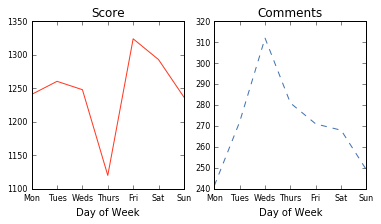

In [91]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline

# Create plot template with two graph boxes
fig = plt.figure(figsize = (720/120, 420/120), dpi = 120)

# Create subplot 1 for median scores
ax1 = fig.add_subplot(1, 2, 1)
score_com_day['Score'].plot(linestyle='solid', color='#FF3721')
ax1.set_title('Score')
plt.xlabel('Day of Week', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)

# Create subplot 2 for median comments
ax2 = fig.add_subplot(1, 2, 2)
score_com_day['Comments'].plot(linestyle='dashed', color='#4271AE')
ax2.set_title('Comments')
plt.xlabel('Day of Week', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)

# Export graph as figure
fig.savefig("/Users/jburchell/projects/t-redactyl/content/figure/score_comments_plot.png", 
            dpi = 120, bbox_inches='tight')

<img src="/figure/score_comments_plot.png" title="Score/comments plot" alt="Plot of score and comments per day of week" style="display: block; margin: auto;" />

Now we can see it a bit more clearly! Posts that are created on weekdays, particularly Thursdays, have lower scores than those created on a weekend. However, the opposite is true for the number of comments, where posts created on a weekend and early in the week receive far fewer comments than those created mid-week (Tuesday to Thursday).

Before we start trying to interpret these results, let's test whether the day of the week is significantly related to the score and comments. We'll use another omnibus test, the [Kruskal–Wallis one-way analysis of variance](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) to test this, which can be performed using the `kruskalwallis` function in the `scipy` package. This tells us whether there is a significant difference between any of the days of the week in the score or number of comments, but again doesn't tell us which days of the week are significantly different.

In [87]:
d = {}
for key, value in rel_df.groupby('DayOfWeek'):
        d['%s' % key] = value['Score']
        
H, p_val = stats.mstats.kruskalwallis(d['Mon'], d['Tues'], d['Weds'], d['Thurs'], 
                                       d['Fri'], d['Sat'], d['Sun'])
print "The test statistic is %1.3f, and the significance level is %1.3f." % (H, p_val)

The test statistic is 11.280, and the significance level is 0.080.


We can see that the day of the week does **not** significantly affect the score a post receives, with the Kruskall-Wallis test having a p-value of 0.080.

In [88]:
d = {}
for key, value in rel_df.groupby('DayOfWeek'):
        d['%s' % key] = value['Comments']
        
H, p_val = stats.mstats.kruskalwallis(d['Mon'], d['Tues'], d['Weds'], d['Thurs'], 
                                       d['Fri'], d['Sat'], d['Sun'])
print "The test statistic is %1.3f, and the significance level is %1.3f." % (H, p_val)

The test statistic is 13.387, and the significance level is 0.037.


However, the day of the week does significantly affect the number of comments a post attracts (although at p = 0.037 in a sample of 1,000, this is not the most compelling result). Perhaps readers are a bit more motivated to spend time on this subreddit during the week, maybe procrastinating from work? We'd again need post-hoc analyses to confirm the difference lies between mid-week and the rest of the week.

## Summing up

In our brief analysis we found that male posters are significantly older than female posters, that male and female posters write in about different topics, and that the day of the week affects the number of comments a post attracts (but not its overall score).

There are a few issues that limit the analysis we should think about. As I mentioned in the last post, there are missing data in `Flair` (due to the posts getting locked), `PosterAge` and `PosterSex`. You'll remember I replaced some missing data using the "Update" flag in the titles, but was unable to replace any other type of flair, and this likely overrepresented the number of update flairs in the sample. We also can't assume that age and sex are randomly missing - it could be that posters that were careless about how they structured their title were very distressed, for example. Finally, remember that these are the **top** posts on the subreddit of all time, which means that they may not be representative of typical poster/reader interactions on /r/relationships.

There are also a couple of issues to consider with my analysis. I've already pointed out that (in the interests of being lazy) I used non-parametric tests without confirming that I could have used parametric equivalents. This means both that the test is more conservative and that we lose any effect size measures. I also didn't perform any post-hoc tests, which means what we can conclude about the relationships between sex and flairs, and day of the week and number of comments is limited. Finally, a p-value of 0.05 might be a bit cheeky when we have a relatively large sample of 1,000 observations, so it might have been more informative to drop that to something like 0.01.

And that's it! We're now at the end of this tutorial series. I hope you now feel confident with collecting, wrangling, analysing and interpreting JSON-encoded data from reddit, and perhaps this tutorial has also helped you with issues with observational data more generally. Happy analysing!